## In this notebook, we will
1. Import reduction potential data for over 5000 molecules
2. Perform data cleaning operations (correlated feature elimination and p-value hypothesis testing) using customised classes and methods.
3. Split data into 80-20 training and testing tests and save as .csv files for training ML models in the following notebooks

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random 
import os

from Functions import ChemClean
from Functions import Descriptors

In [2]:
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors 

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import statsmodels.api as sm

## Load data from url

In [3]:
url='https://raw.githubusercontent.com/akashjn/DataScience/main/Data/BTZ_5442mols_smiles_redpot.csv'
data=pd.read_csv(url)
data=data.sample(frac=1)
data.index=range(data.shape[0])
data.head()

,SMILES,ERed
0,Cc1cc2c(c3nsnc13)CCCCN2C,1.45
1,CCc1c2c(c(C)c3nsnc13)N(C)CN2CC,1.08
2,CCCN1CCN(C(C)C)c2cc3nsnc3c(NC)c21,1.35
3,CCCC1COc2c(cc3nsnc3c2OC(C)=O)O1,1.67
4,CC(C)CN(C)CCc1c2c(cc3nsnc13)C1CCC2C1,1.46


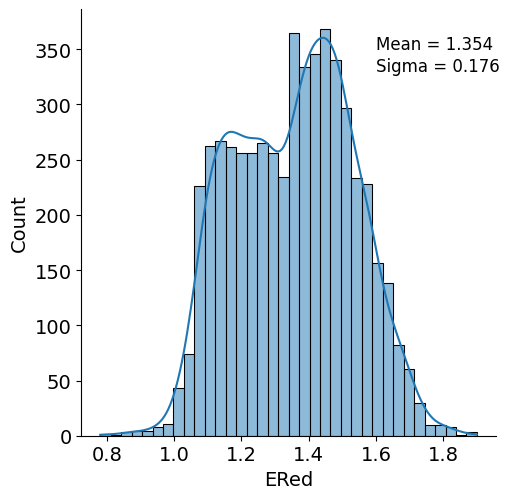

In [5]:
ax=sns.displot(data, x="ERed",kde=True)
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(data['ERed']),3)),fontsize=12)
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(data['ERed']),3)),fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ERed',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.show()

## Generate descriptors using Descriptors.py

In [6]:
%%time
p=Descriptors.desc(data['SMILES'])
df_rdkit=p.RDkit_descriptors()
print(df_rdkit.shape)
df_rdkit.head()

(5442, 208)
CPU times: total: 59.6 s
Wall time: 1min 2s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.147367,-0.072696,12.147367,0.000971,0.640974,305.407,286.255,305.131031,112,0,...,0,0,0,0,0,0,0,0,0,0
1,6.294270,0.173249,6.294270,0.173249,0.842727,320.462,296.270,320.167082,120,0,...,0,0,0,0,0,0,0,0,0,0
2,5.778107,0.887595,5.778107,0.887595,0.845157,320.462,296.270,320.167082,120,0,...,0,0,0,0,0,0,0,0,0,0
3,4.461551,0.364694,4.461551,0.364694,0.758063,293.440,270.256,293.167417,110,0,...,0,0,0,0,0,0,0,0,0,0
4,11.835137,-0.001568,11.835137,0.001568,0.468807,291.380,274.244,291.115381,106,0,...,0,0,0,0,0,0,0,0,0,0


## Dimensionality Reduction using customised methods from ChemClean.py
1. Remove features with NaN
2. Remove unique features
3. Low variance filter
4. High correlation filter

In [7]:
p=ChemClean.clean(df_rdkit)

In [8]:
p.remove_nan().head()
p.remove_unique().head()
p.remove_columns_low_std(0.1).head()
df_model=p.remove_corr_features(0.7)

# VERIFY HOW FEATURES ARE REMOVED AFTER CHECKING FOR CORRELATION


print(df_model.shape)
df_model.head()

Removing 0 columns with nan, if any
Before: df.shape=(5442, 208)
After: df.shape=(5442, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5442, 208)
After: df.shape=(5442, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70
(5442, 39)


,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,12.147367,-0.072696,305.407,1.476190,10.143957,-2.718543,2.287274,-1.89,17.101832,5.516701,...,7.452232,7.622335,2.032891,1,1,0,0,0,2,0
1,6.294270,0.173249,320.462,1.181818,10.097846,-2.409287,2.218804,-1.56,16.720788,5.749512,...,4.807287,12.695983,0.000000,0,1,0,2,0,2,0
2,5.778107,0.887595,320.462,1.090909,9.993986,-2.401083,2.329692,-1.56,16.720788,5.749512,...,4.805463,7.554921,3.915650,0,1,0,1,1,2,0
3,4.461551,0.364694,293.440,1.100000,10.066091,-2.144483,2.656427,-1.56,11.033401,0.000000,...,0.000000,9.455775,1.947457,3,0,0,0,1,1,0
4,11.835137,-0.001568,291.380,1.500000,10.146741,-2.283984,2.410552,-1.89,24.149504,5.516701,...,4.428561,5.392587,3.847782,0,1,0,0,0,2,0


In [9]:
# target=data['ERed']
target=data
features=df_model.copy()
features.shape
features.head()

,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,12.147367,-0.072696,305.407,1.476190,10.143957,-2.718543,2.287274,-1.89,17.101832,5.516701,...,7.452232,7.622335,2.032891,1,1,0,0,0,2,0
1,6.294270,0.173249,320.462,1.181818,10.097846,-2.409287,2.218804,-1.56,16.720788,5.749512,...,4.807287,12.695983,0.000000,0,1,0,2,0,2,0
2,5.778107,0.887595,320.462,1.090909,9.993986,-2.401083,2.329692,-1.56,16.720788,5.749512,...,4.805463,7.554921,3.915650,0,1,0,1,1,2,0
3,4.461551,0.364694,293.440,1.100000,10.066091,-2.144483,2.656427,-1.56,11.033401,0.000000,...,0.000000,9.455775,1.947457,3,0,0,0,1,1,0
4,11.835137,-0.001568,291.380,1.500000,10.146741,-2.283984,2.410552,-1.89,24.149504,5.516701,...,4.428561,5.392587,3.847782,0,1,0,0,0,2,0


#### ********************************************************************************************************************************************************************

### <span style="color:red">For convenience, the previous feature engineering operations are packaged in a single python file, with unit tests implemented to check for correctness.</span>

### UnitTesting/FeaturesTest.py contains a function called feature_reduction() which combines the prevous feature engineering operations

### UnitTesting/FeaturesTest.py contains a class called TestFeatureEngineering which implements the unit test.

In [10]:
from UnitTesting import FeaturesTest

feature_size_after_reduction=FeaturesTest.feature_reduction(df_rdkit)
feature_size_after_reduction

Removing 0 columns with nan, if any
Before: df.shape=(5442, 208)
After: df.shape=(5442, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5442, 208)
After: df.shape=(5442, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70


(5442, 39)

### <span style="color:red">Unit Testing is successful</span>

In [12]:
current=os.getcwd()

os.chdir(os.path.expanduser('UnitTesting'))

!python -m unittest FeaturesTest.py

os.chdir(os.path.expanduser(current))

Removing 0 columns with nan, if any
Before: df.shape=(5442, 208)
After: df.shape=(5442, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5442, 208)
After: df.shape=(5442, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70


.
----------------------------------------------------------------------
Ran 1 test in 0.571s

OK


#### ********************************************************************************************************************************************************************

## Recursive feature elimination using p-value test; using Linear Regression

### p-values calculated using ordinary least squares fit

In [13]:
mod = sm.OLS(target['ERed'],features)
fii = mod.fit()
fii.summary2().tables[1].head()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
MaxEStateIndex,0.032146,0.002572,12.498263,2.343020e-35,0.027104,0.037188
MinEStateIndex,0.024024,0.008888,2.702920,6.894821e-03,0.006600,0.041449
MolWt,-0.006181,0.000579,-10.669231,2.587961e-26,-0.007317,-0.005045
FpDensityMorgan1,0.040480,0.011253,3.597217,3.245165e-04,0.018419,0.062540
BCUT2D_MWLOW,0.019360,0.011387,1.700172,8.915612e-02,-0.002963,0.041683


### Feature Ranking using Recursive elimination of all features whose p-value < alpha (=0.02)

In [14]:
alpha=0.02
for a in range(len(features.columns)):
    mod = sm.OLS(target['ERed'],features)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    cols=[]
    for i in range(len(p_values)):
        if p_values[i]>alpha:
            cols.append(p_values.index[i])
    if len(cols)==0:
        break
    print(len(cols),'descriptors eliminated in iteration',str(a+1))
    features.drop(columns=cols,inplace=True)
    
print('Final model has',features.shape,'desriptors')
columns=features.columns
columns

5 descriptors eliminated in iteration 1
1 descriptors eliminated in iteration 2
1 descriptors eliminated in iteration 3
Final model has (5442, 32) desriptors


Index(['MaxEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_LOGPLOW',
       'BalabanJ', 'HallKierAlpha', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA10', 'SMR_VSA4', 'SMR_VSA5', 'SlogP_VSA3', 'SlogP_VSA4',
       'SlogP_VSA6', 'EState_VSA4', 'EState_VSA6', 'EState_VSA7',
       'EState_VSA8', 'VSA_EState2', 'VSA_EState9', 'NHOHCount',
       'NumAliphaticHeterocycles', 'fr_ArN', 'fr_Ndealkylation1',
       'fr_bicyclic', 'fr_unbrch_alkane'],
      dtype='object')

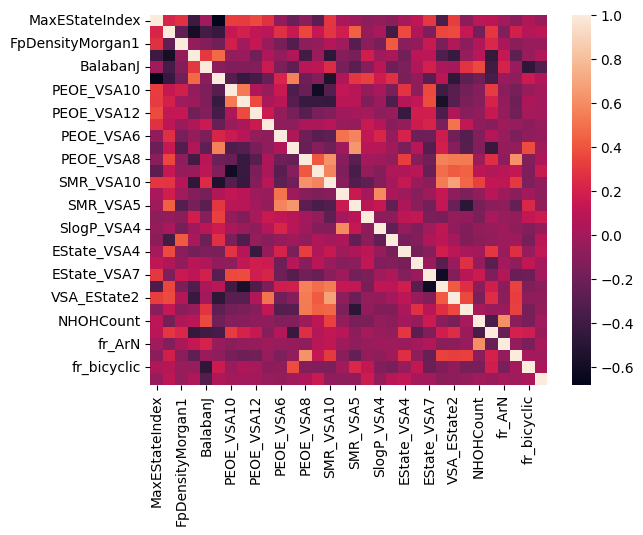

In [16]:
sns.heatmap(features.corr())
plt.show()

## Split into 80-20 training and testing sets and save to csv files

In [38]:
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.2,random_state=42)

In [39]:
features_train.index=range(features_train.shape[0])
features_train.to_csv('Data/features_train.csv')
features_test.index=range(features_test.shape[0])
features_test.to_csv('Data/features_test.csv')
target_train.index=range(target_train.shape[0])
target_train.to_csv('Data/target_train.csv')
target_test.index=range(target_test.shape[0])
target_test.to_csv('Data/target_test.csv')

In [40]:
print('Training set contains',target_train.shape[0],'entries')
print('Testing set contains',target_test.shape[0],'entries')

Training set contains 4353 entries
Testing set contains 1089 entries


## Scale the features and save to csv files

In [41]:
scaler=StandardScaler()

In [42]:
features_train=scaler.fit_transform(features_train)
features_test=scaler.transform(features_test)

In [43]:
features_train=pd.DataFrame(features_train,columns=columns)
features_train.to_csv('Data/features_train_scaled.csv',index=False)
features_test=pd.DataFrame(features_test,columns=columns)
features_test.to_csv('Data/features_test_scaled.csv',index=False)

### Visualise distribution of reduction potentials in the training and testing datasets

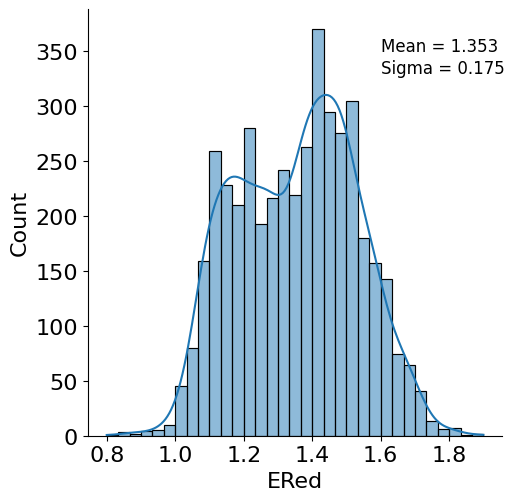

In [9]:
Ered_train=pd.read_csv('Data/target_train.csv',index_col=0)
ax=sns.displot(Ered_train,x='ERed',kde=True)
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(Ered_train['ERed']),3)),fontsize=14)
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(Ered_train['ERed']),3)),fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('ERed',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.show()

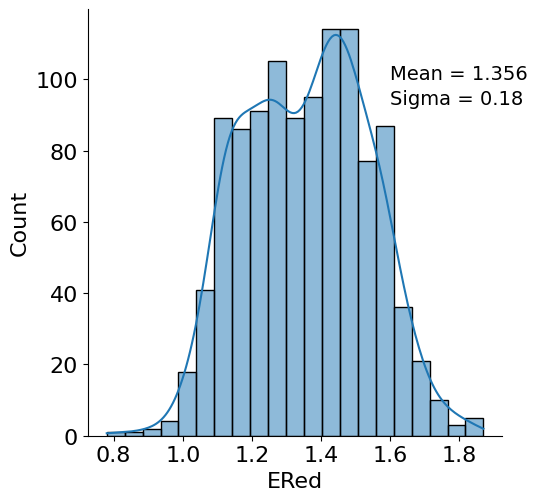

In [15]:
Ered_test=pd.read_csv('Data/target_test.csv',index_col=0)
ax=sns.displot(Ered_test,x='ERed',kde=True)
plt.text(1.6,100,'Mean = '+str(np.round(np.mean(Ered_test['ERed']),3)),fontsize=14)
plt.text(1.6,93,'Sigma = '+str(np.round(np.std(Ered_test['ERed']),3)),fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('ERed',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.show()

In the next notebook, <font color = blue>2.MolRedPot_Regression.ipynb
</font>, we will develop cross-validated simple linear and ensemble regression models to predict the reduction potential of these molecules.